In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras import initializers
from tensorflow.keras import backend as K
import tensorflow as tf
import time

x_train shape: (300,)
y_train shape: (300,)


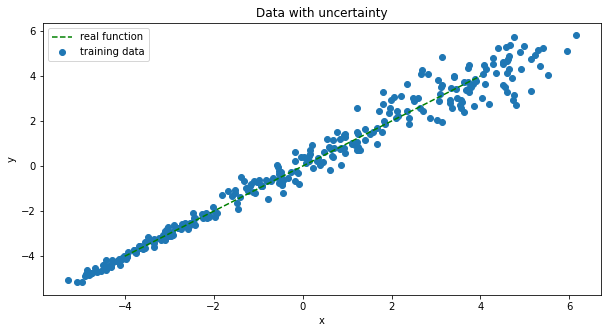

In [ ]:
x_func = np.linspace(-4,4,300)
y_func = x_func

x_train = np.linspace(-5,-2,100) + np.random.randn(100)*0.1

y_train = np.linspace(-5,-2,100) + np.random.randn(100)*0.1

x_train = np.concatenate((x_train, np.linspace(-1.5,1.5,100) + np.random.randn(100)*0.25), axis=0)
y_train = np.concatenate((y_train, np.linspace(-1.5,1.5,100) + np.random.randn(100)*0.25), axis=0)

x_train = np.concatenate((x_train, np.linspace(2,5,100) + np.random.randn(100)*0.6), axis=0)
y_train = np.concatenate((y_train, np.linspace(2,5,100) + np.random.randn(100)*0.6), axis=0)

x_test = np.linspace(-10,10,100)

print("x_train shape:", np.shape(x_train))
print("y_train shape:", np.shape(y_train))

fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.scatter(x_train, y_train, label='training data')
ax.plot(x_func, y_func, ls='--', label='real function', color='green')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
ax.set_title('Data with uncertainty');

In [ ]:
# function for creating a fully connected neural network of any architecture
# the number of neurons in each layer is defined by layers_shape
# the droupout_proba indicates if dropout layers should be added
def architecture(layers_shape, input_dim, output_dim, dropout_proba, reg, act='relu', verbose=False):
    inputs = Input(shape=(input_dim,))
    hidden = Dense(layers_shape[0], activation=act,
                   kernel_regularizer=l2(reg))(inputs)
    for i in range(len(layers_shape)-1):
        if dropout_proba > 0:
          hidden = Dropout(dropout_proba)(hidden, training=True)
        hidden = Dense(layers_shape[i+1], activation=act, kernel_regularizer=l2(reg))(hidden)
    if dropout_proba > 0:
      hidden = Dropout(dropout_proba)(hidden, training=True)
    outputs = Dense(output_dim, kernel_regularizer=l2(reg))(hidden) 
    model = Model(inputs, outputs)
    if verbose:
      model.summary()
    return model

In [ ]:
# aleatoric loss function
def aleatoric_loss(y_true, y_pred):
    N = y_true.shape[0]
    se = K.pow((y_true[:,0]-y_pred[:,0]),2)
    inv_std = K.exp(-y_pred[:,1])

    mse = K.mean(inv_std*se)
    
    reg = K.mean(y_pred[:,1])
    
    return 0.5*(mse + reg)

In [ ]:
# reshape tensors to support two outputs
x_train_reshaped = x_train.reshape(x_train.shape[0], 1)
y_train_reshaped = np.vstack([y_train, np.zeros(y_train.shape)]).T
print("x_train shape:", np.shape(x_train_reshaped))
print("y_train shape:", np.shape(y_train_reshaped))

x_train shape: (300, 1)
y_train shape: (300, 2)


In [ ]:
# model with support for aleatoric uncertainty
# note output dimension is 2: y and std
model_with_dropout_aleatoric = architecture(layers_shape=[20,40,80,40,20], 
                                            input_dim= 1, output_dim=2, 
                                            dropout_proba=0.2, reg=0.00004,
                                            act='relu', verbose=0)

Text(0, 0.5, 'Loss')

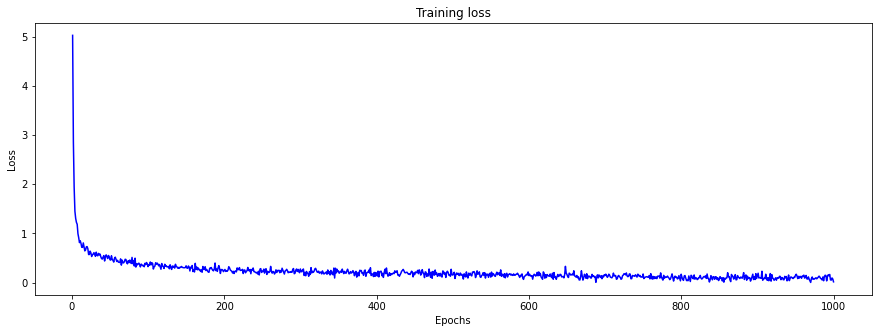

In [ ]:
# training the network
model_with_dropout_aleatoric.compile(optimizer='adam', 
                                     loss=aleatoric_loss, metrics=['mae'])
history = model_with_dropout_aleatoric.fit(x_train_reshaped, y_train_reshaped, 
                                 batch_size=20, epochs=1000, shuffle=True, verbose=0)
# training performance
epochs = range(1, len(history.history['loss']) + 1)
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(epochs, history.history['loss'], 'b')
ax.set_title('Training loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

In [ ]:
# function to predict on the test dataset, and the epistemic uncertainty
def predictor(model, 
              X_test, T=100):
    probs = []
    for _ in range(T):
        probs += [model.predict(X_test, verbose=0)]
    return probs

In [ ]:
start = time.time()
p = np.array(predictor(model_with_dropout_aleatoric, x_test, T=500))
end = time.time()
print('Elapsed time:', end-start)

# Epistemic and aleatoric uncertainty
mean = np.mean(p[:,:,0], axis=0)

epistemic_std = np.std(p[:,:,0], axis=0)

aleatoric_std = np.exp(0.5*np.mean(p[:,:,1], axis=0))

std_y = np.sqrt(epistemic_std**2 + aleatoric_std**2)

Elapsed time: 16.215595483779907


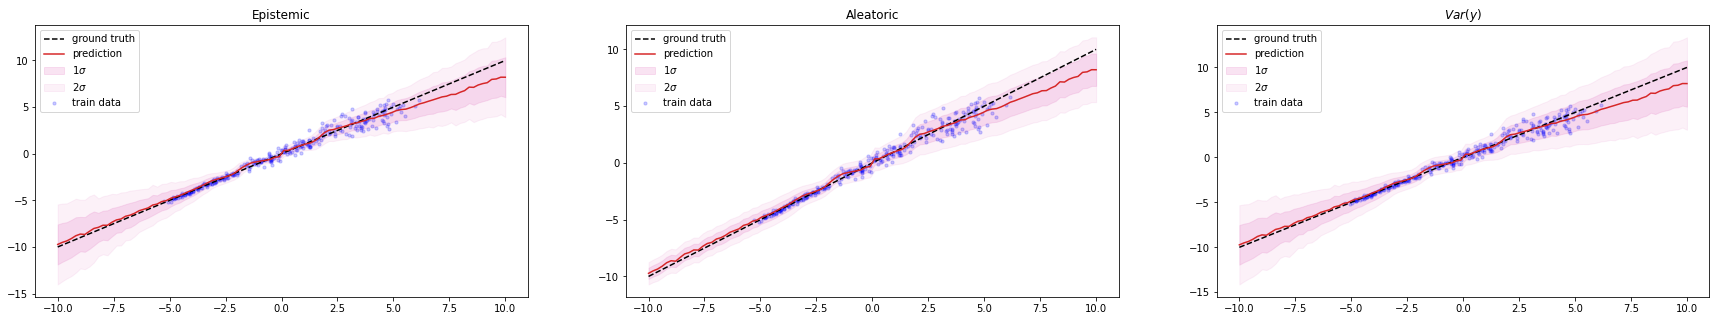

In [ ]:
# plot aleatoric uncertainty
fig, axs = plt.subplots(1,3, figsize=(30,5))

# Epistemic uncertainty
axs[0].fill_between(x_test, mean-epistemic_std, mean+epistemic_std, facecolor='tab:pink', color='tab:pink',alpha=0.2, label=r'$1\sigma$')
axs[0].fill_between(x_test, mean-epistemic_std*2, mean+epistemic_std*2, facecolor='tab:pink', color='tab:pink',alpha=0.1, label=r'$2\sigma$')
axs[0].set_title('Epistemic')
# Aleatoric uncertainty
axs[1].fill_between(x_test, mean-aleatoric_std, mean+aleatoric_std, facecolor='tab:pink', color='tab:pink',alpha=0.2, label=r'$1\sigma$')
axs[1].fill_between(x_test, mean-aleatoric_std*2, mean+aleatoric_std*2, facecolor='tab:pink', color='tab:pink',alpha=0.1, label=r'$2\sigma$')
axs[1].set_title('Aleatoric')
# Predictive uncertainty
axs[2].fill_between(x_test, mean-std_y, mean+std_y, facecolor='tab:pink', color='tab:pink',alpha=0.2, label=r'$1\sigma$')
axs[2].fill_between(x_test, mean-std_y*2, mean+std_y*2, facecolor='tab:pink', color='tab:pink',alpha=0.1, label=r'$2\sigma$')
axs[2].set_title(r'$Var(y)$')
for i in range(len(axs)):
    axs[i].scatter(x_train_reshaped, y_train_reshaped[:,0], label='train data', color="blue", s=10, alpha=0.2)
    axs[i].plot(x_test, x_test, ls='--', label='ground truth', color='black')
    axs[i].plot(x_test, mean, color='tab:red', label='prediction')
    axs[i].legend(loc="upper left")

plt.show()

In [ ]:
# Sample from Teacher
teacher_sample = np.array(predictor(model_with_dropout_aleatoric, x_train, T=500))
teacher_mean = np.mean(teacher_sample[:,:,0], axis=0)
#epistemic_std = np.std(sample_teacher[:,:,0], axis=0)
teacher_aleatoric = np.exp(0.5*np.mean(teacher_sample[:,:,1], axis=0))
#std_y = np.sqrt(epistemic_std**2 + aleatoric_std**2)

In [ ]:
std = teacher_aleatoric
#std = std_y
x_student_train_stack = []
y_student_train_stack = []
for _ in range(10):
    x_student_train_stack.append(x_train)
    y_student_train = teacher_mean + std * np.random.normal(0,1,(len(teacher_mean),))
    y_student_train = y_student_train.reshape(y_student_train.shape[0], 1)
    y_student_train_stack.append(y_student_train)
x_student_train_stack = np.concatenate(x_student_train_stack)
y_student_train_stack = np.concatenate(y_student_train_stack)

In [ ]:
# shen loss function
def shen_loss(y_true, y_pred):
    Ls = K.mean(0.5*K.exp(-y_pred[:,1]) * K.pow(y_true[:,0] - y_pred[:,0],2) + 0.5*y_pred[:,1])
    Lt = K.abs(y_true[:,0] - y_pred[:,0])
    L = Ls + Lt
    return K.mean(L)

In [ ]:
# model with support for aleatoric uncertainty
# note output dimension is 2: y and std
# function for creating a fully connected neural network of any architecture
# the number of neurons in each layer is defined by layers_shape
# the droupout_proba indicates if dropout layers should be added
def architecture_shen(layers_shape, input_dim, output_dim, dropout_proba, reg, act='relu', verbose=False):
    inputs = Input(shape=(input_dim,))
    hidden = Dense(layers_shape[0], activation=act,
                   kernel_regularizer=l2(reg))(inputs)
    for i in range(len(layers_shape)-1):
        if dropout_proba > 0:
          hidden = Dropout(dropout_proba)(hidden)
        hidden = Dense(layers_shape[i+1], activation=act, kernel_regularizer=l2(reg))(hidden)
    if dropout_proba > 0:
      hidden = Dropout(dropout_proba)(hidden)
    outputs = Dense(output_dim, kernel_regularizer=l2(reg))(hidden) 
    model = Model(inputs, outputs)
    if verbose:
      model.summary()
    return model
  
model_shen = architecture_shen(layers_shape=[20,40,80,40,20], input_dim= 1, output_dim=2, 
                                  dropout_proba=0, reg=0.00001, act='relu', verbose=1)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_30 (Dense)             (None, 20)                40        
_________________________________________________________________
dense_31 (Dense)             (None, 40)                840       
_________________________________________________________________
dense_32 (Dense)             (None, 80)                3280      
_________________________________________________________________
dense_33 (Dense)             (None, 40)                3240      
_________________________________________________________________
dense_34 (Dense)             (None, 20)                820       
_________________________________________________________________
dense_35 (Dense)             (None, 2)                 42  

Text(0, 0.5, 'Loss')

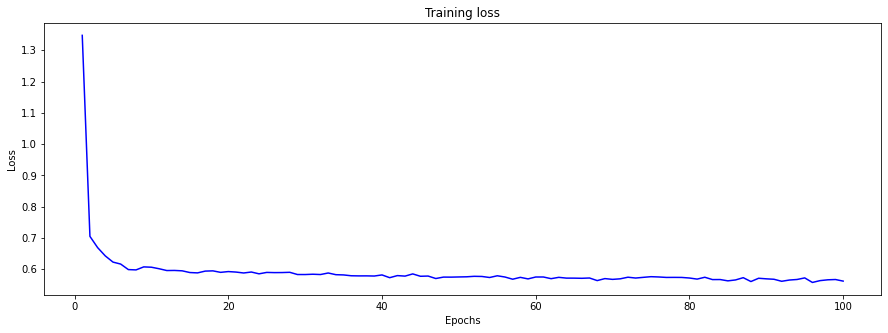

In [ ]:
# training the network
model_shen.compile(optimizer='rmsprop', 
                                     loss=shen_loss, metrics=['mae'])
history = model_shen.fit(x_student_train_stack, y_student_train_stack, 
                                 batch_size=20, epochs=200, shuffle=True, verbose=0)
# training performance
epochs = range(1, len(history.history['loss']) + 1)
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(epochs, history.history['loss'], 'b')
ax.set_title('Training loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

In [ ]:
start = time.time()
output = model_shen.predict(np.linspace(-10,10,300),verbose=0)
end = time.time()
print('Elapsed time:', end-start)

Elapsed time: 0.08806991577148438


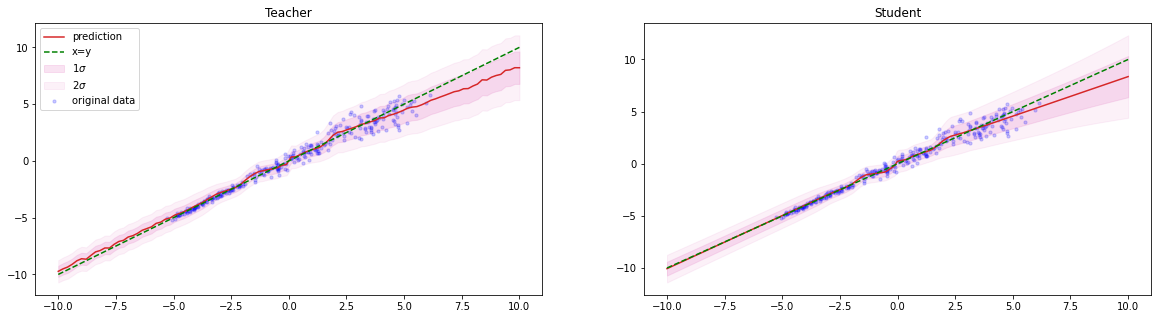

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(20,5))

axs[0].plot(x_test, mean, color='tab:red', label='prediction')
axs[0].fill_between(x_test, mean-aleatoric_std, mean+aleatoric_std, facecolor='orange', color='tab:pink',alpha=0.2, label=r'$1\sigma$')
axs[0].fill_between(x_test, mean-aleatoric_std*2, mean+aleatoric_std*2, facecolor='orange', color='tab:pink',alpha=0.1, label=r'$2\sigma$')
axs[0].set_title('Teacher')
axs[1].plot(np.linspace(-10,10,300), output[:,0], color='tab:red', label='prediction')
axs[1].fill_between(np.linspace(-10,10,300), output[:,0]-np.exp(0.5*output[:,1]), output[:,0]+np.exp(0.5*output[:,1]), facecolor='orange', color='tab:pink',alpha=0.2, label=r'$1\sigma$')
axs[1].fill_between(np.linspace(-10,10,300), output[:,0]-np.exp(0.5*output[:,1])*2, output[:,0]+np.exp(0.5*output[:,1])*2, facecolor='orange', color='tab:pink',alpha=0.1, label=r'$2\sigma$')
axs[1].set_title('Student')
for i in range(len(axs)):
    axs[i].scatter(x_train, y_train, s=10, color='blue', label='original data', alpha=0.2)
    axs[i].plot(x_test, x_test, ls='--', label='x=y', color='green')
axs[0].legend()